In [1]:
import torch, math
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
from math import factorial, sqrt, pi
import torch
import functorch

In [27]:
import importlib
import Master_funcs
importlib.reload(Master_funcs)

<module 'Master_funcs' from '/Users/aleksandersekkelsten/UIO/FYS4480/Master_funcs.py'>

In [124]:
def Energy_plot(V,f_net):
    M = 300            # number of grid points per coordinate (adjust for accuracy)
    L=3.0
    x_grid = np.linspace(-L, L, M)  # shape: (M,)
    X1, X2 = np.meshgrid(x_grid, x_grid, indexing='ij')
    positions_np = np.stack([X1.flatten(), X2.flatten()], axis=-1)  
    positions_np = positions_np[:, :, np.newaxis]  # reshape to (M*M, 2, 1)
    positions = torch.tensor(positions_np, dtype=torch.float32)
    
    psi_vals = psi_plot_fn(positions)
    # Reshape to a 2D grid of shape (M, M)
    psi_grid = psi_vals.view(M, M)
    
    # --- 5. Compute the Laplacian using finite differences ---
    # Convert psi_grid to a numpy array for integration.
    psi_np = psi_grid.detach().cpu().numpy()
    dx = (2*L) / (M - 1)  # grid spacing
    laplacian_np = np.zeros_like(psi_np)
    for i in range(1, M-1):
        for j in range(1, M-1):
            d2psi_dx1 = (psi_np[i+1, j] - 2*psi_np[i, j] + psi_np[i-1, j]) / (dx**2)
            d2psi_dx2 = (psi_np[i, j+1] - 2*psi_np[i, j] + psi_np[i, j-1]) / (dx**2)
            laplacian_np[i, j] = d2psi_dx1 + d2psi_dx2
    
    V_harm = 0.5 * (X1**2 + X2**2)
    V_int = V / (sigma * np.sqrt(2*np.pi)) * np.exp(-((X1 - X2)**2) / (2*sigma**2))
    V_total = V_harm + V_int
    
    T_density = -0.5 * psi_np * laplacian_np
    V_density = psi_np**2 * V_total
    energy_density = T_density + V_density
    
    num = np.trapz(np.trapz(energy_density, x_grid, axis=1), x_grid, axis=0)
    denom = np.trapz(np.trapz(psi_np**2, x_grid, axis=1), x_grid, axis=0)
    
    E_estimated = num / denom
    print("Estimated Energy:", E_estimated)
    
    # Optionally, plot the probability density |psi|^2
    plt.figure(figsize=(8, 6))
    plt.contourf(X1, X2, psi_np**2, levels=50, cmap='viridis')
    plt.colorbar(label=r'$|\psi(x_1,x_2)|^2$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Probability Density of the 2-Particle Wavefunction')
    plt.show()
    return E_estimated 

In [39]:
def train_model(V,E,f_net,optimizer,N_collocation=200,n_epochs=800):
    # --- User-defined parameters ---
    Ngrid = 50       # Number of grid points per particle coordinate
    x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
    mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
    positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
    positions = positions.unsqueeze(-1)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        x = torch.normal(0.0, 0.2, size=(N_collocation,n_particles,d))
        SD = slater_determinant_from_C_occ(x, C_occ)
        n_permutations = 10
        perm_list = [torch.randperm(n_particles) for _ in range(n_permutations)]
        f_out= symmetrized_exp_nn_output(f_net, x, n_permutations=10)
        f_out=f_out.reshape(len(f_out))
        
        psi = SD * f_out
        norm=torch.norm(psi, p=2)
        
        laplacian =  laplacian = compute_laplacian_fast(psi_fn, x, permutations=perm_list)#compute_laplacian_fast(psi_fn, x)
        V_harmonic = 0.5 * (x**2).sum(dim=(1,2)).view(-1,1)
        V_int = compute_interaction_potential(x, V, sigma)
        V_total = V_harmonic + V_int
        H_psi = -0.5 * laplacian + V_total * psi
        residual = H_psi - (E)*psi

        norm_loss = (psi.norm() - 1)**2*0.1
        loss_pde = torch.mean((residual)**2)*100/norm
        loss = loss_pde + norm_loss #+ loss_sym

        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:05d}:  Pde Loss = {loss_pde.item():.3e}, "
                  f"Norm Loss = {norm_loss.item():.3e}")#,  = {E_param.item():.3f}")
            
            if epoch %20==0:
                SD_vals = slater_determinant_from_C_occ(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
                f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=10)#f_net(positions)#torch.exp(f_net(positions)).view(-1, 1)                        # shape: (Ngrid**n_particles, 1)
                psi_vals =  SD_vals * f_vals                            # shape: (Ngrid**n_particles, 1)
                psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
                density = psi_sq.clone()
                for axis in sorted(range(1, n_particles), reverse=True):
                    density = torch.trapz(density, x_grid, dim=axis)
                n_x = n_particles * density  # shape: (Ngrid,)
                
                # --- 7. Plot the one-body density ---
                x_vals = x_grid.detach().cpu().numpy()
                n_vals = n_x.detach().cpu().numpy()
                
                plt.figure(figsize=(4, 3))
                plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
                plt.xlabel('x')
                plt.ylabel(r'$n(x_1)$')
                plt.title(f'One-Body Density for a {n_particles}-Particle 1D System')
                plt.legend()
                plt.show()
    return f_net

In [40]:
import torch
import functorch

def symmetrized_nn_output(NN, x, n_permutations=10, permutations=None):
    """
    Enforces permutation symmetry by averaging NN outputs over several 
    permutations of the particle indices.
    
    Args:
        NN: A callable neural network that accepts input x of shape 
            (batch, n_particles, d).
        x: Tensor of shape (batch, n_particles, d).
        n_permutations: Number of permutations to average over.
        permutations: (Optional) A list of precomputed permutation indices of length n_permutations.
        
    Returns:
        A tensor with the averaged (symmetrized) output.
    """
    batch_size, n_particles, _ = x.shape
    outputs = []
    
    if permutations is None:
        # If no permutations are provided, generate them (not recommended within vmap)
        for _ in range(n_permutations):
            perm = torch.randperm(n_particles)
            outputs.append(NN(x[:, perm, :]))
    else:
        for perm in permutations:
            outputs.append(NN(x[:, perm, :]))
    
    outputs = torch.stack(outputs, dim=0)  # shape: (n_permutations, batch, output_dim)
    return outputs.mean(dim=0)

def symmetrized_exp_nn_output(NN, x, n_permutations=10, permutations=None):
    """
    Applies the exponential to the symmetrized NN output,
    implementing f(x)=exp(NN(x)).
    """
    return torch.exp(symmetrized_nn_output(NN, x, n_permutations, permutations))

def compute_laplacian_fast(psi_fn, x, permutations=None):
    """
    Compute the Laplacian of psi for a batch of configurations using functorch.jacrev.
    
    Args:
        psi_fn: A function mapping a single configuration x (shape: (n_particles, d))
                to a scalar psi (0-dim tensor). Must be pure.
        x: Tensor of shape (batch, n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.
        
    Returns:
        Tensor of shape (batch, 1) containing the Laplacian of psi.
    """
    batch, n_particles, d = x.shape
    D = n_particles * d
    # Flatten each configuration to shape (D,)
    x_flat = x.view(batch, D)
    
    def f(xx):
        # Reshape xx to (n_particles, d) and compute psi.
        return psi_fn(xx.view(n_particles, d), permutations=permutations)
    
    def single_hessian(xx):
        # Compute the Hessian via double jacrev.
        return functorch.jacrev(functorch.jacrev(f))(xx)
    
    # Vectorize single_hessian over the batch dimension.
    hessians = functorch.vmap(single_hessian)(x_flat)  # shape: (batch, D, D)
    # Laplacian is the trace of the Hessian.
    laplacian = torch.diagonal(hessians, dim1=1, dim2=2).sum(dim=1, keepdim=True)
    return laplacian

def psi_fn(x_single, permutations=None):
    """
    Compute the wavefunction for a single configuration.
    
    Args:
        x_single: Tensor of shape (n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.
    
    Returns:
        A scalar tensor representing psi.
    """
    # Add a batch dimension: shape (1, n_particles, d)
    x_batch = x_single.unsqueeze(0)
    SD_val = slater_determinant_from_C_occ(x_batch, C_occ)  # Assumed to be defined globally.
    # Use the symmetrized exponential NN output.
    f_val = symmetrized_exp_nn_output(f_net, x_batch, n_permutations=10, permutations=permutations)
    psi_val = (SD_val * f_val).squeeze()  # Return a scalar tensor.
    return psi_val

In [41]:
def slater_determinant_from_C_occ(x_config, C_occ, normalize=True):
    """
    Compute the Slater determinant for each configuration in a differentiable manner.
    
    Args:
        x_config: Tensor of shape (batch, n_electrons, d) with electron positions (assume d=1).
        C_occ:    Tensor of shape (n_basis, n_electrons) containing the occupied orbital coefficients.
        normalize: If True, include the factor 1/sqrt(n_electrons!).
        
    Returns:
        Tensor of shape (batch, 1) with the Slater determinant value for each configuration.
    """
    batch, n_electrons, d = x_config.shape
    n_basis = C_occ.shape[0]
    SD_vals = []
    
    for i in range(batch):
        # Extract positions for configuration i; shape (n_electrons,)
        x_i = x_config[i, :, 0]  # assuming d = 1
        # Evaluate basis functions at these positions; shape (n_electrons, n_basis)
        phi_vals = evaluate_basis_functions_torch(x_i, n_basis)
        # Build the molecular orbital matrix:
        # Each molecular orbital is a linear combination: psi_j(x) = sum_p phi_p(x)*C_occ[p, j]
        # For all electrons, this is: psi_mat = phi_vals @ C_occ, shape (n_electrons, n_electrons)
        psi_mat = torch.matmul(phi_vals, C_occ)
        # Compute the determinant in a differentiable manner.
        # You can use torch.linalg.det or (for stability) torch.linalg.slogdet.
        det_val = torch.linalg.det(psi_mat)
        SD_vals.append(det_val)
    
    SD_vals = torch.stack(SD_vals).view(batch, 1)
    if normalize:
        SD_vals = SD_vals / math.sqrt(math.factorial(n_electrons))
    return SD_vals
def evaluate_basis_functions_torch(x, n_basis):
    """
    Evaluate the 1D harmonic oscillator eigenfunctions at positions x in a differentiable manner.
    
    Args:
        x: Tensor of shape (N,), where N is the number of positions.
        n_basis: Number of basis functions to evaluate.
        
    Returns:
        Tensor of shape (N, n_basis) where each column is one basis function evaluated at x.
    """
    N = x.shape[0]
    phi_vals = []  # will hold each phi_n evaluated at x
    # For n = 0:
    norm0 = 1.0 / math.sqrt(math.sqrt(math.pi))
    phi0 = norm0 * torch.exp(-x**2 / 2)
    phi_vals.append(phi0)
    
    if n_basis > 1:
        # For n = 1:
        norm1 = 1.0 / math.sqrt(2 * math.sqrt(math.pi))
        phi1 = norm1 * (2 * x) * torch.exp(-x**2 / 2)
        phi_vals.append(phi1)
    
    # For higher n, use recurrence for Hermite polynomials:
    # H_0(x) = 1, H_1(x) = 2x, and for n>=1: H_{n+1}(x) = 2x H_n(x) - 2n H_{n-1}(x)
    if n_basis > 2:
        H_prev_prev = torch.ones_like(x)  # H_0(x)
        H_prev = 2 * x                     # H_1(x)
        for n in range(1, n_basis - 1):
            H_curr = 2 * x * H_prev - 2 * n * H_prev_prev
            # Normalization: 1/sqrt(2^n n! sqrt(pi))
            norm = 1.0 / math.sqrt((2**(n+1)) * math.factorial(n+1) * math.sqrt(math.pi))
            phi_n = norm * torch.exp(-x**2 / 2) * H_curr
            phi_vals.append(phi_n)
            H_prev_prev, H_prev = H_prev, H_curr

    # Stack along the second dimension: shape (N, n_basis)
    phi_vals = torch.stack(phi_vals, dim=1)
    return phi_vals

In [42]:
def compute_interaction_potential(x, V, sigma):
    batch_size, n_particles, d = x.shape
    V_int = torch.zeros(batch_size, device=x.device)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r = x[:, i, :] - x[:, j, :]
            r_sq = (r**2).sum(dim=1)
            V_int += torch.exp(-r_sq / (2 * sigma**2))
    return (V / (sigma * np.sqrt(2 * np.pi))) * V_int.view(-1, 1)
def psi_plot_fn(positions):
    # positions: Tensor of shape (batch, n_particles, 1)
    SD_vals = slater_determinant_from_C_occ(positions, C_occ)   # (batch, 1)
    f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=10)#f_net(positions).view(-1, 1)                        # (batch, 1)
    return SD_vals * f_vals   # (batch, 1)


In [5]:

# Main Code Block
# ---------------------------
L = 5        # Spatial domain [-L, L]
n_grid = 100   # Number of grid points
grid = np.linspace(-L, L, n_grid)

n_basis = 2    # Number of basis functions (should be ≥ n_electrons)
n_electrons = 2

# 1. Initialize the harmonic oscillator basis
basis = Master_funcs.initialize_harmonic_basis(n_basis, grid)

# 2. Compute one-electron integrals (kinetic + harmonic potential)
Hcore = Master_funcs.one_electron_integral(basis, grid)

# 3. Define the Gaussian interaction potential on the grid using your form:
#    V(x,x') = V/(sigma*sqrt(2*pi))*exp(-((x-x')^2)/(2*sigma^2))
V = 0#20.0       # Interaction strength
sigma = 0.5   # Gaussian width
V_interaction = Master_funcs.gaussian_interaction_potential(grid, V, sigma)
# 4. Pre-calculate the two-electron integrals in the basis using the Gaussian potential
print("Pre-calculating two-electron integrals with Gaussian interaction...")
two_body = Master_funcs.compute_two_body_integrals(basis, V_interaction, grid)
print("Two-electron integrals computed.")
V=0
# 5. Run the Hartree-Fock procedure
print("Starting Hartree-Fock iterations...")
C_occ, orbital_energies = Master_funcs.hartree_fock(n_electrons, basis, grid, Hcore, two_body)
C_occ=torch.Tensor(C_occ)

Pre-calculating two-electron integrals with Gaussian interaction...
Two-electron integrals computed.
Starting Hartree-Fock iterations...
Iteration 0: Δ = 0.000e+00
1.9980890973605332


In [ ]:
n_particles=2
Ngrid = 60       # Number of grid points per particle coordinate
L=3
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)

SD_vals = Master_funcs.slater_determinant_from_C_occ(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
                   # shape: (Ngrid**n_particles, 1)
psi_vals = SD_vals                            # shape: (Ngrid**n_particles, 1)
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles}-Particle 1D System')
plt.legend()
plt.show()


In [6]:
import torch.nn as nn
import torch.optim as optim
# =======================
# 5. Neural Network (PINN) for the Correction Factor f(x;θ)
# =======================
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_hidden=1):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.GELU())
        for _ in range(n_hidden):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.GELU())
        layers.append(nn.Linear(hidden_dim, 1))  # output a scalar correction factor
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        # x is of shape (batch_size, n_particles, d)
        # Flatten the input to (batch_size, n_particles * d)
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)
        return self.net(x_flat)


In [126]:
device="cpu"
d = 1
n_particles=2
N_collocation = 200 # Number of collocation points per training iteration
learning_rate = 1e-3
n_epochs = 500

# Test points
input_dim = n_particles * d
f_net = PINN(input_dim=input_dim, hidden_dim=64, n_hidden=2).to(device)
optimizer = optim.Adam(list(f_net.parameters()), lr=learning_rate)

Epoch 00000:  Pde Loss = 1.071e-03, Norm Loss = 3.447e-04


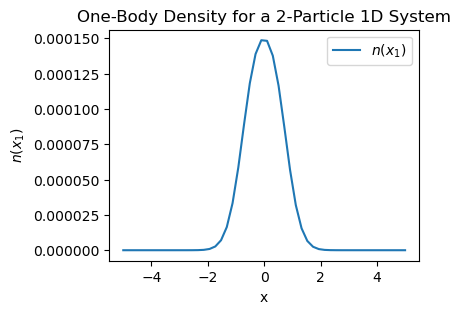

Epoch 00010:  Pde Loss = 8.015e-04, Norm Loss = 3.324e-04
Epoch 00020:  Pde Loss = 8.989e-04, Norm Loss = 7.754e-05


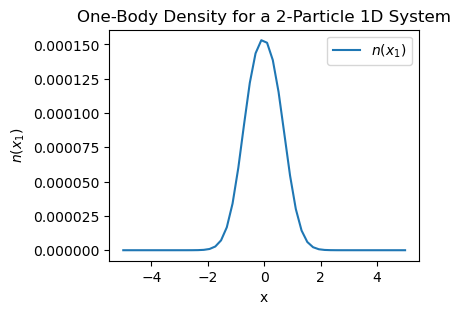

KeyboardInterrupt: 

In [135]:
train_model(-10,0.6,f_net,optimizer)

Estimated Energy: 0.8286951846943474


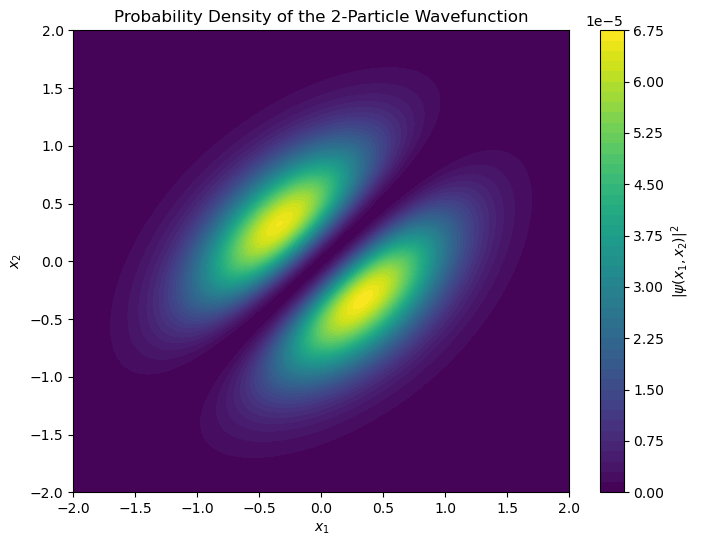

0.8286951846943474

In [136]:
Energy_plot(-10,f_net)

In [79]:
# Test points
input_dim = n_particles * d
f_net = PINN(input_dim=input_dim, hidden_dim=64, n_hidden=2).to(device)
optimizer = optim.Adam(list(f_net.parameters()), lr=learning_rate)

Epoch 00000:  Pde Loss = 8.280e-04, Norm Loss = 5.993e-05


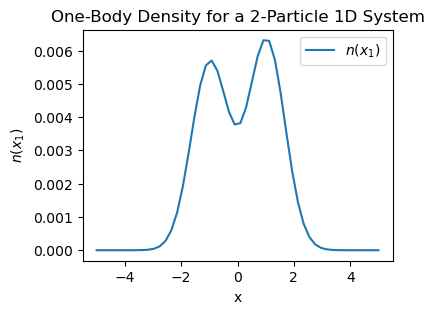

KeyboardInterrupt: 

In [109]:
train_model(10,2.42,f_net,optimizer)

Estimated Energy: 2.4558271296249665


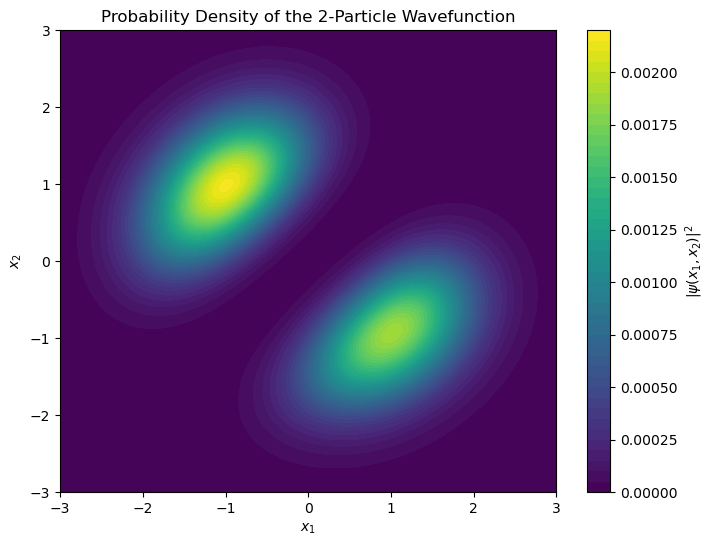

2.4558271296249665

In [111]:
Energy_plot(10,f_net)

Epoch 00000:  Pde Loss = 8.244e+00, Norm Loss = 7.846e+01


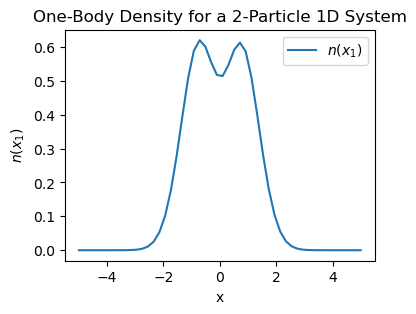

Epoch 00010:  Pde Loss = 6.767e+00, Norm Loss = 4.333e+01
Epoch 00020:  Pde Loss = 4.726e+00, Norm Loss = 2.593e+01


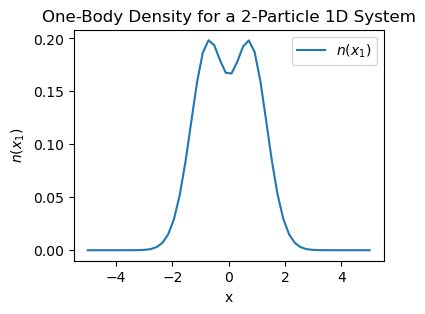

Epoch 00030:  Pde Loss = 2.825e+00, Norm Loss = 7.178e+00
Epoch 00040:  Pde Loss = 1.402e+00, Norm Loss = 1.282e+00


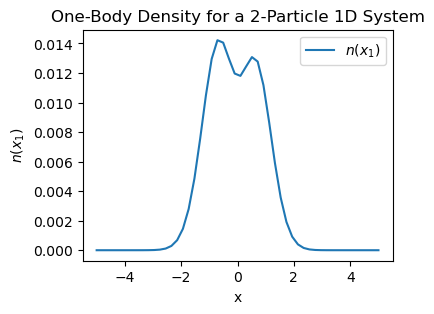

Epoch 00050:  Pde Loss = 7.662e-01, Norm Loss = 2.494e-01
Epoch 00060:  Pde Loss = 4.418e-01, Norm Loss = 3.243e-02


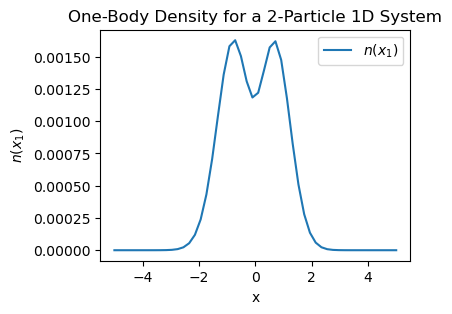

Epoch 00070:  Pde Loss = 3.276e-01, Norm Loss = 1.988e-03
Epoch 00080:  Pde Loss = 2.540e-01, Norm Loss = 2.308e-04


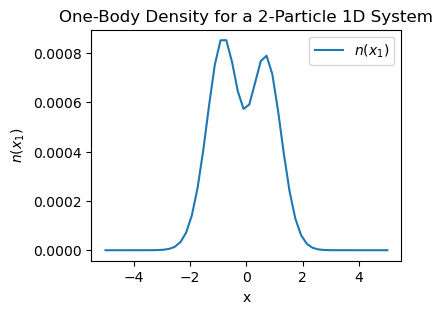

Epoch 00090:  Pde Loss = 2.299e-01, Norm Loss = 3.606e-03
Epoch 00100:  Pde Loss = 2.011e-01, Norm Loss = 6.505e-03


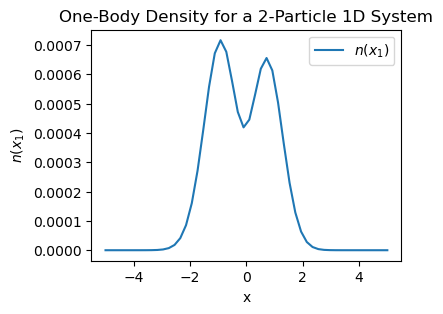

Epoch 00110:  Pde Loss = 1.672e-01, Norm Loss = 8.116e-03
Epoch 00120:  Pde Loss = 1.512e-01, Norm Loss = 1.437e-02


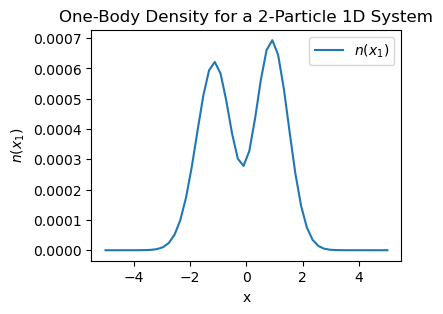

Epoch 00130:  Pde Loss = 1.393e-01, Norm Loss = 2.240e-02
Epoch 00140:  Pde Loss = 1.275e-01, Norm Loss = 1.793e-02


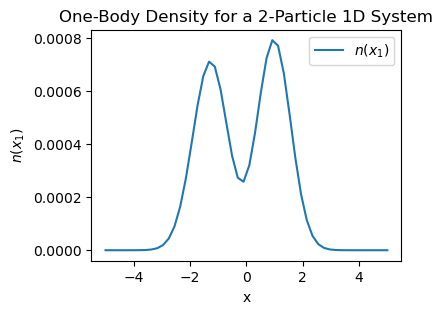

Epoch 00150:  Pde Loss = 1.212e-01, Norm Loss = 2.389e-02
Epoch 00160:  Pde Loss = 1.042e-01, Norm Loss = 2.170e-02


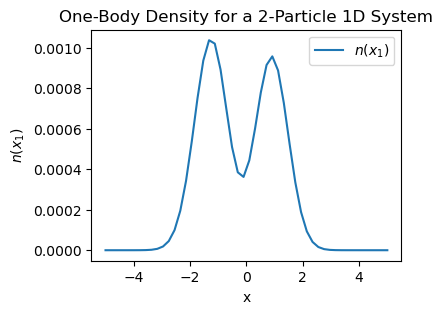

Epoch 00170:  Pde Loss = 9.604e-02, Norm Loss = 2.586e-02
Epoch 00180:  Pde Loss = 8.930e-02, Norm Loss = 2.882e-02


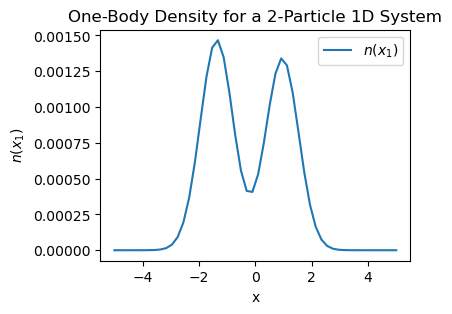

Epoch 00190:  Pde Loss = 7.924e-02, Norm Loss = 3.200e-02
Epoch 00200:  Pde Loss = 7.187e-02, Norm Loss = 3.355e-02


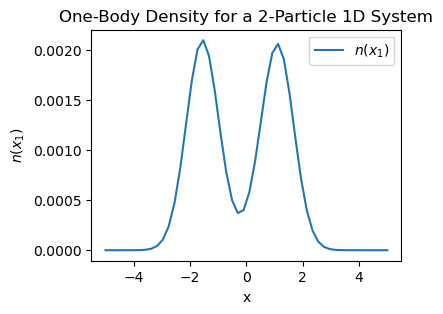

Epoch 00210:  Pde Loss = 7.322e-02, Norm Loss = 3.937e-02
Epoch 00220:  Pde Loss = 6.382e-02, Norm Loss = 3.457e-02


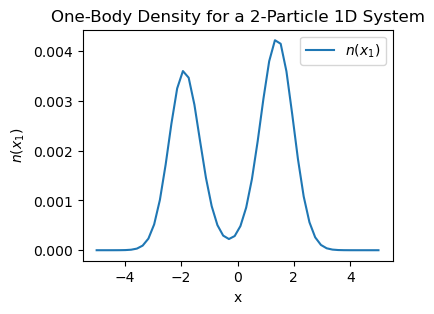

Epoch 00230:  Pde Loss = 6.074e-02, Norm Loss = 3.834e-02
Epoch 00240:  Pde Loss = 5.169e-02, Norm Loss = 3.842e-02


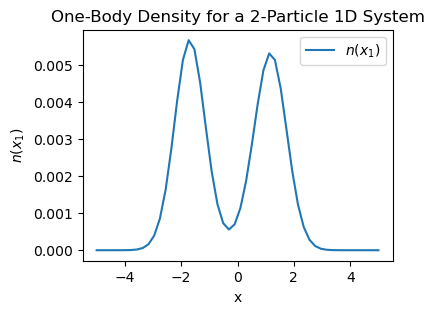

Epoch 00250:  Pde Loss = 4.887e-02, Norm Loss = 4.132e-02
Epoch 00260:  Pde Loss = 5.186e-02, Norm Loss = 4.220e-02


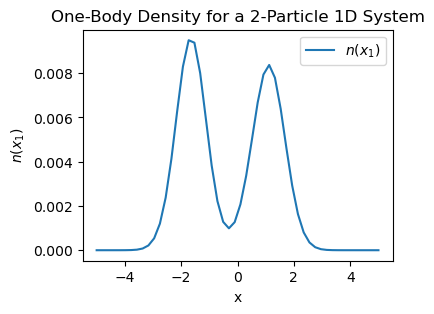

Epoch 00270:  Pde Loss = 4.317e-02, Norm Loss = 3.955e-02
Epoch 00280:  Pde Loss = 4.264e-02, Norm Loss = 4.228e-02


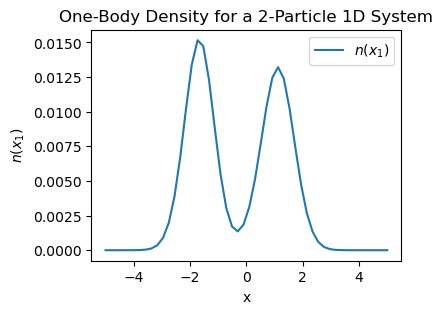

Epoch 00290:  Pde Loss = 3.728e-02, Norm Loss = 3.603e-02
Epoch 00300:  Pde Loss = 3.230e-02, Norm Loss = 3.907e-02


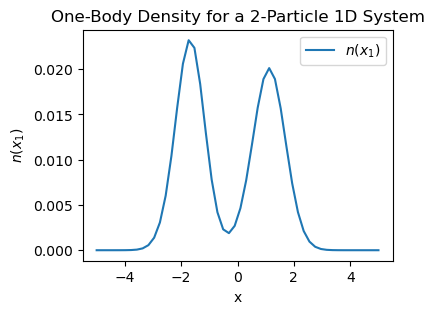

Epoch 00310:  Pde Loss = 3.531e-02, Norm Loss = 3.881e-02
Epoch 00320:  Pde Loss = 3.025e-02, Norm Loss = 4.443e-02


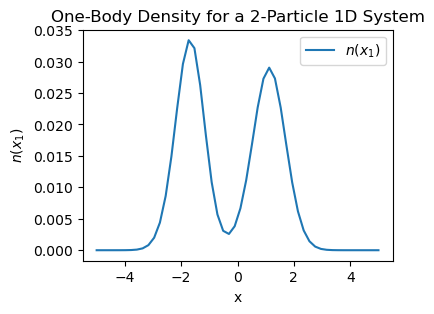

Epoch 00330:  Pde Loss = 3.237e-02, Norm Loss = 4.193e-02
Epoch 00340:  Pde Loss = 2.814e-02, Norm Loss = 3.685e-02


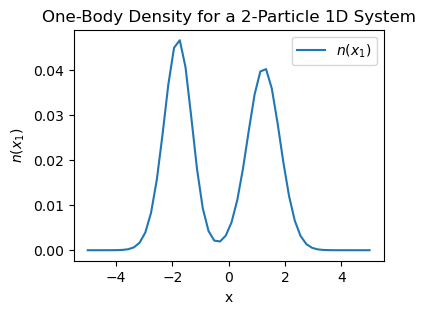

Epoch 00350:  Pde Loss = 2.766e-02, Norm Loss = 3.774e-02
Epoch 00360:  Pde Loss = 3.015e-02, Norm Loss = 3.379e-02


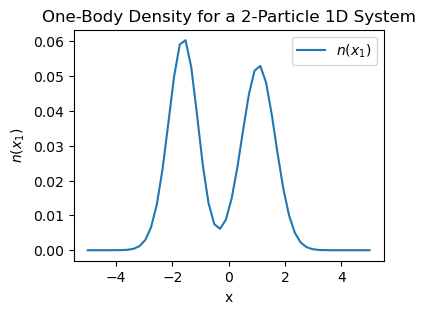

Epoch 00370:  Pde Loss = 2.646e-02, Norm Loss = 3.955e-02
Epoch 00380:  Pde Loss = 2.798e-02, Norm Loss = 3.441e-02


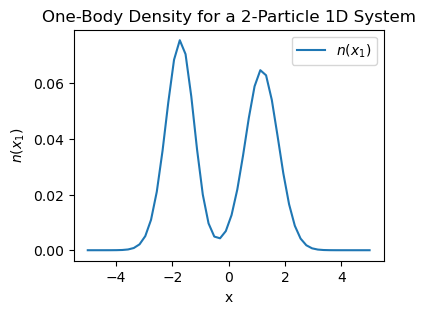

Epoch 00390:  Pde Loss = 3.244e-02, Norm Loss = 3.209e-02
Epoch 00400:  Pde Loss = 2.800e-02, Norm Loss = 3.784e-02


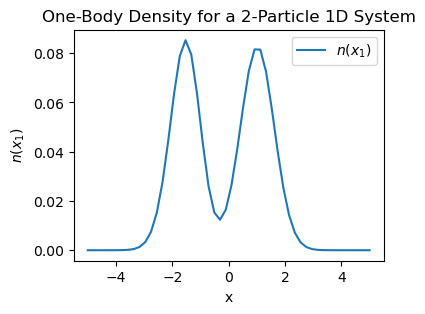

Epoch 00410:  Pde Loss = 2.605e-02, Norm Loss = 3.147e-02
Epoch 00420:  Pde Loss = 2.813e-02, Norm Loss = 3.608e-02


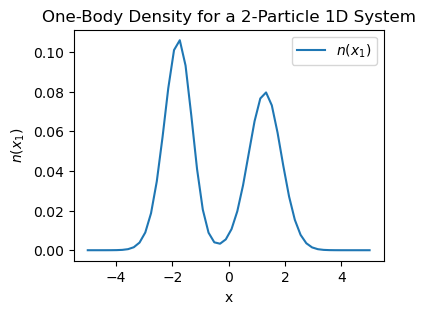

Epoch 00430:  Pde Loss = 3.259e-02, Norm Loss = 2.813e-02
Epoch 00440:  Pde Loss = 2.868e-02, Norm Loss = 3.110e-02


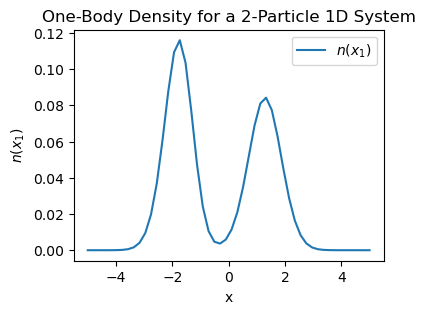

Epoch 00450:  Pde Loss = 3.015e-02, Norm Loss = 2.718e-02
Epoch 00460:  Pde Loss = 5.488e-02, Norm Loss = 2.342e-02


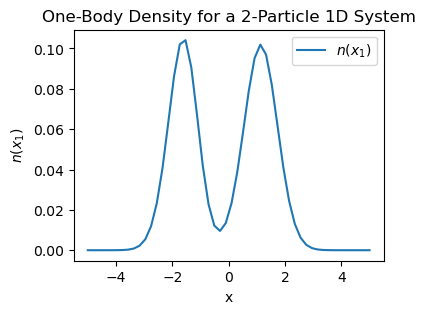

Epoch 00470:  Pde Loss = 3.259e-02, Norm Loss = 2.660e-02
Epoch 00480:  Pde Loss = 3.175e-02, Norm Loss = 3.208e-02


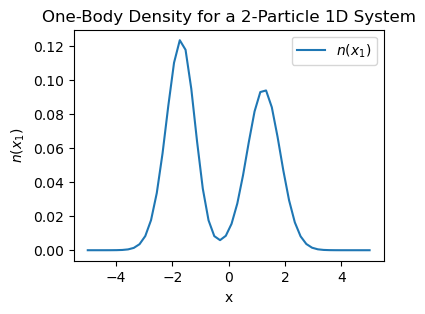

Epoch 00490:  Pde Loss = 3.157e-02, Norm Loss = 2.549e-02
Epoch 00500:  Pde Loss = 3.705e-02, Norm Loss = 2.354e-02


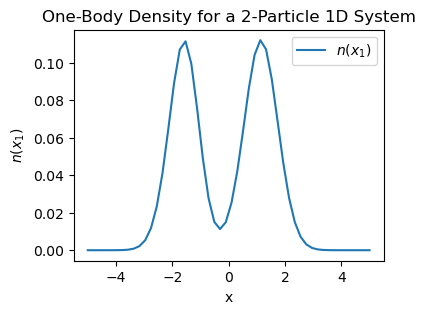

Epoch 00510:  Pde Loss = 3.554e-02, Norm Loss = 2.370e-02
Epoch 00520:  Pde Loss = 3.834e-02, Norm Loss = 1.803e-02


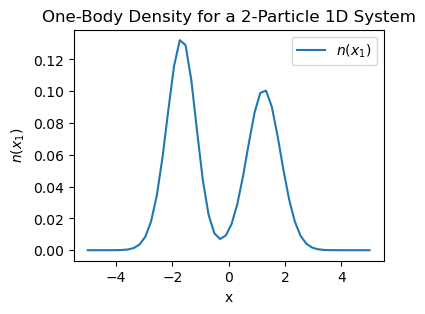

Epoch 00530:  Pde Loss = 3.300e-02, Norm Loss = 2.520e-02
Epoch 00540:  Pde Loss = 4.203e-02, Norm Loss = 1.830e-02


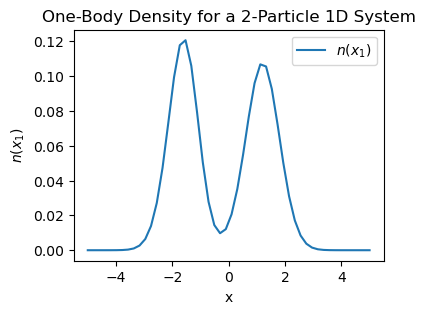

Epoch 00550:  Pde Loss = 3.343e-02, Norm Loss = 2.232e-02
Epoch 00560:  Pde Loss = 3.452e-02, Norm Loss = 1.721e-02


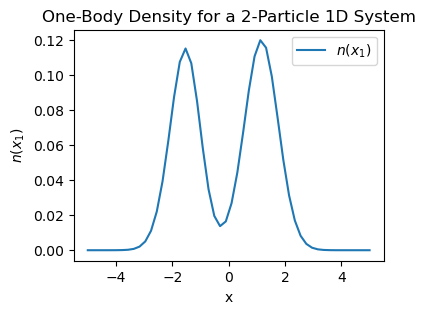

Epoch 00570:  Pde Loss = 3.571e-02, Norm Loss = 1.308e-02
Epoch 00580:  Pde Loss = 3.506e-02, Norm Loss = 1.508e-02


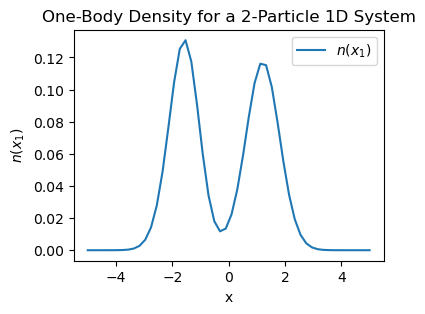

Epoch 00590:  Pde Loss = 2.821e-02, Norm Loss = 1.278e-02
Epoch 00600:  Pde Loss = 3.463e-02, Norm Loss = 1.099e-02


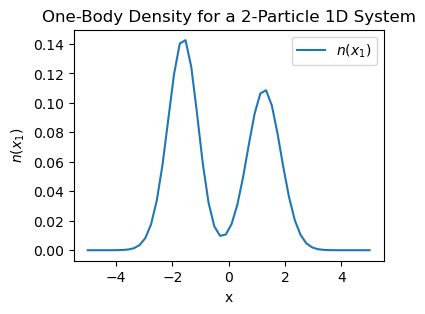

Epoch 00610:  Pde Loss = 3.970e-02, Norm Loss = 1.413e-02
Epoch 00620:  Pde Loss = 3.274e-02, Norm Loss = 1.350e-02


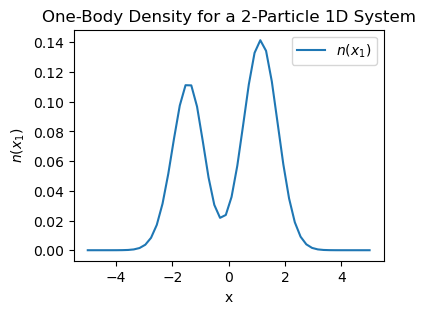

Epoch 00630:  Pde Loss = 3.270e-02, Norm Loss = 1.582e-02
Epoch 00640:  Pde Loss = 3.080e-02, Norm Loss = 1.561e-02


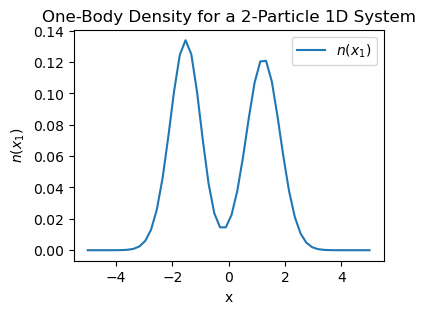

Epoch 00650:  Pde Loss = 3.881e-02, Norm Loss = 7.359e-03
Epoch 00660:  Pde Loss = 5.273e-02, Norm Loss = 9.746e-03


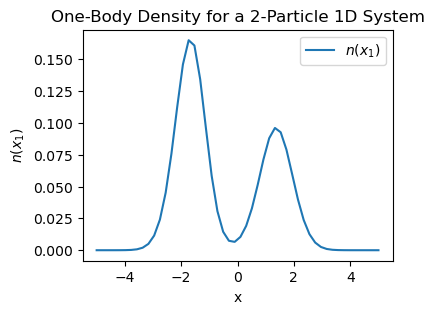

Epoch 00670:  Pde Loss = 3.914e-02, Norm Loss = 6.378e-03
Epoch 00680:  Pde Loss = 4.023e-02, Norm Loss = 1.006e-02


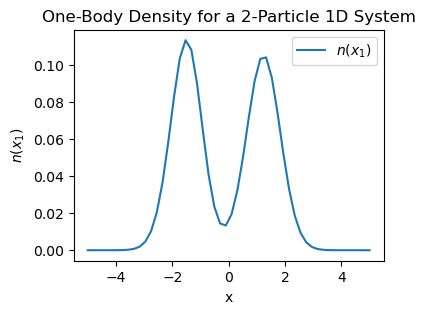

Epoch 00690:  Pde Loss = 3.723e-02, Norm Loss = 1.341e-02
Epoch 00700:  Pde Loss = 4.281e-02, Norm Loss = 7.569e-03


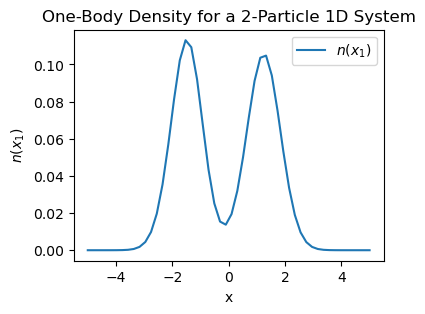

Epoch 00710:  Pde Loss = 3.604e-02, Norm Loss = 7.429e-03
Epoch 00720:  Pde Loss = 2.707e-02, Norm Loss = 9.806e-03


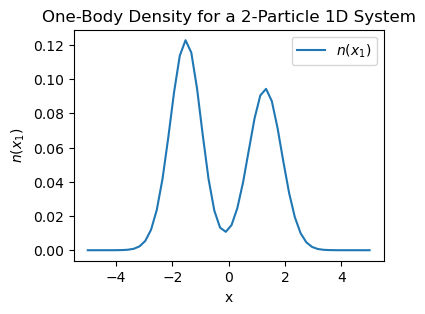

Epoch 00730:  Pde Loss = 5.030e-02, Norm Loss = 9.498e-03
Epoch 00740:  Pde Loss = 4.974e-02, Norm Loss = 8.179e-03


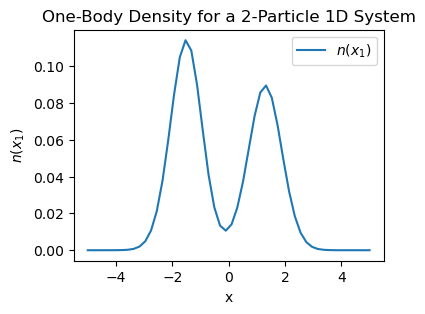

Epoch 00750:  Pde Loss = 3.478e-02, Norm Loss = 5.955e-03
Epoch 00760:  Pde Loss = 3.449e-02, Norm Loss = 5.256e-03


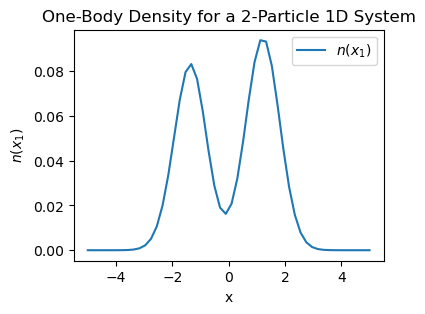

Epoch 00770:  Pde Loss = 5.083e-02, Norm Loss = 3.052e-03
Epoch 00780:  Pde Loss = 3.921e-02, Norm Loss = 6.385e-03


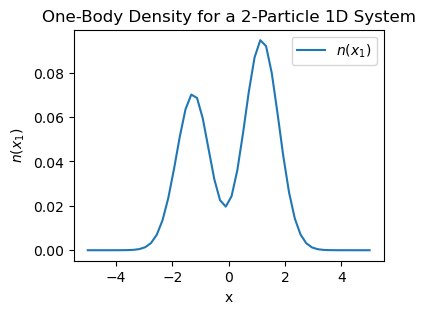

Epoch 00790:  Pde Loss = 3.862e-02, Norm Loss = 3.293e-03


PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [114]:
input_dim = n_particles * d
f_net = PINN(input_dim=input_dim, hidden_dim=64, n_hidden=2).to(device)
optimizer = optim.Adam(list(f_net.parameters()), lr=learning_rate)
train_model(20,2.6,f_net,optimizer)

Epoch 00000:  Pde Loss = 1.109e-02, Norm Loss = 1.645e-04


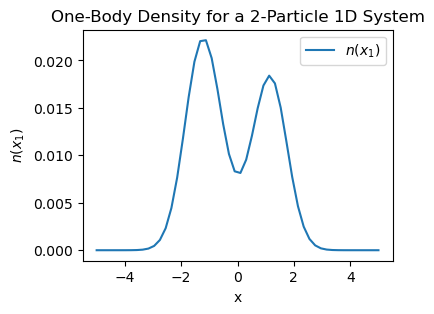

Epoch 00010:  Pde Loss = 1.089e-02, Norm Loss = 1.446e-03
Epoch 00020:  Pde Loss = 8.479e-03, Norm Loss = 3.503e-04


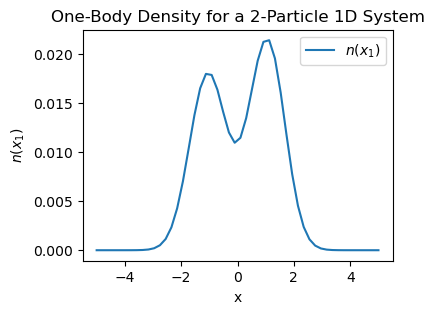

Epoch 00030:  Pde Loss = 9.950e-03, Norm Loss = 3.125e-04
Epoch 00040:  Pde Loss = 1.169e-02, Norm Loss = 7.038e-04


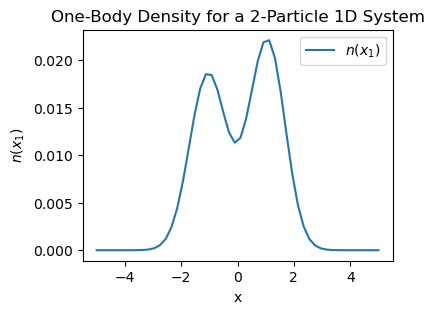

Epoch 00050:  Pde Loss = 8.576e-03, Norm Loss = 6.129e-04
Epoch 00060:  Pde Loss = 9.408e-03, Norm Loss = 3.134e-05


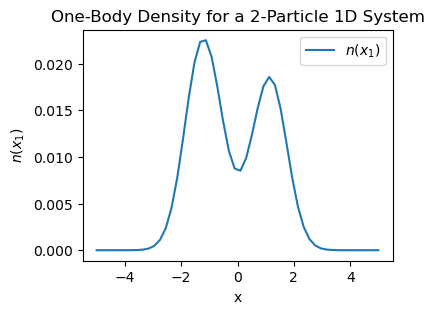

Epoch 00070:  Pde Loss = 1.089e-02, Norm Loss = 6.322e-06


KeyboardInterrupt: 

In [118]:
train_model(20,2.6,f_net,optimizer)

Estimated Energy: 2.647632306206989


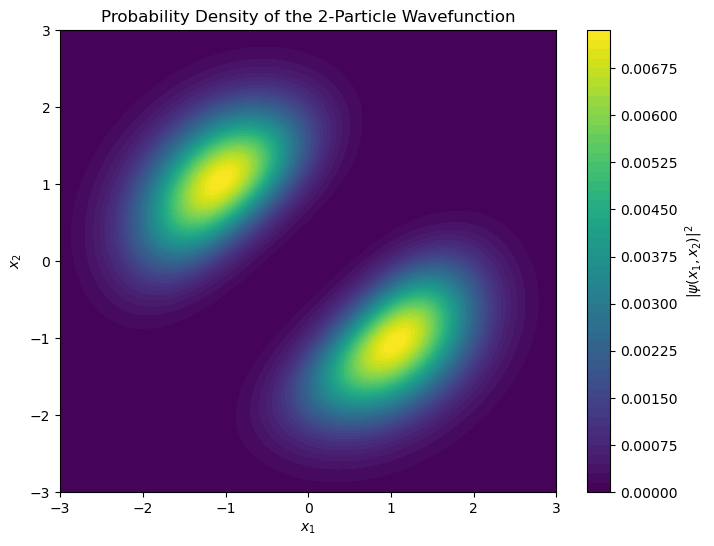

2.647632306206989

In [119]:
Energy_plot(20,f_net)

Epoch 00000:  Pde Loss = 4.290e+00, Norm Loss = 1.001e+02


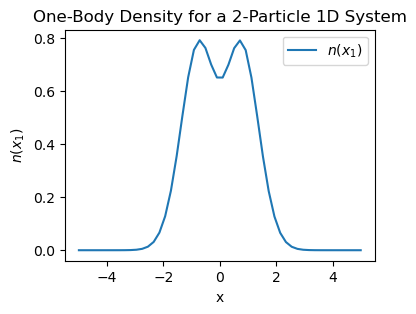

Epoch 00010:  Pde Loss = 3.205e+00, Norm Loss = 7.105e+01
Epoch 00020:  Pde Loss = 2.451e+00, Norm Loss = 2.323e+01


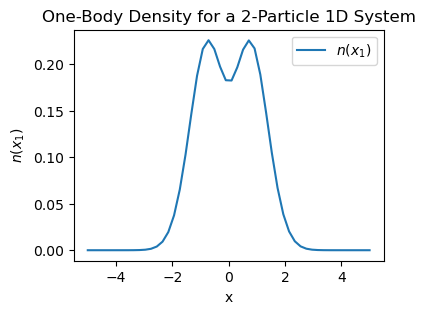

Epoch 00030:  Pde Loss = 1.184e+00, Norm Loss = 6.390e+00
Epoch 00040:  Pde Loss = 5.075e-01, Norm Loss = 9.373e-01


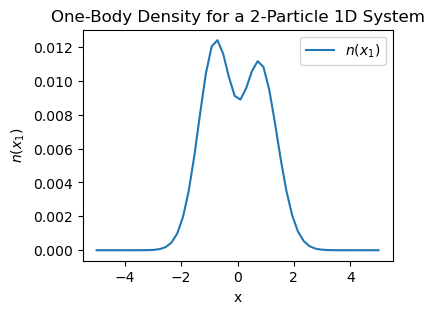

Epoch 00050:  Pde Loss = 3.179e-01, Norm Loss = 7.443e-02
Epoch 00060:  Pde Loss = 1.877e-01, Norm Loss = 2.598e-02


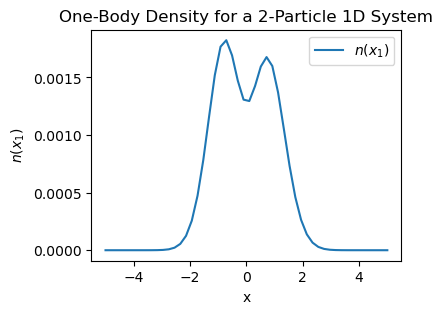

Epoch 00070:  Pde Loss = 1.640e-01, Norm Loss = 8.587e-03
Epoch 00080:  Pde Loss = 1.375e-01, Norm Loss = 5.158e-03


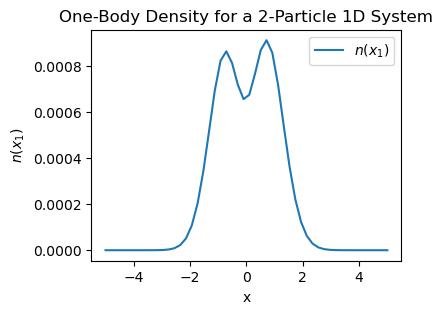

Epoch 00090:  Pde Loss = 1.125e-01, Norm Loss = 3.263e-04
Epoch 00100:  Pde Loss = 1.126e-01, Norm Loss = 6.961e-05


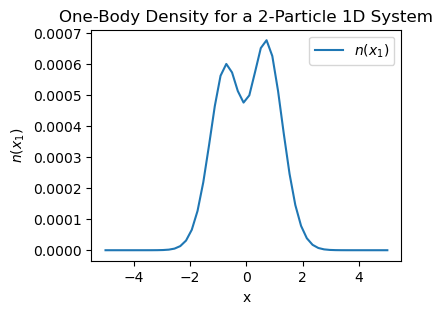

Epoch 00110:  Pde Loss = 1.085e-01, Norm Loss = 7.039e-05
Epoch 00120:  Pde Loss = 9.861e-02, Norm Loss = 6.970e-04


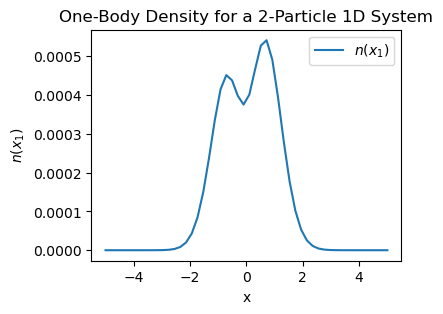

Epoch 00130:  Pde Loss = 9.971e-02, Norm Loss = 1.652e-03
Epoch 00140:  Pde Loss = 9.876e-02, Norm Loss = 6.004e-03


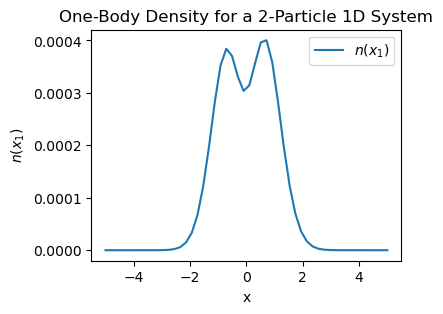

Epoch 00150:  Pde Loss = 8.648e-02, Norm Loss = 5.646e-03
Epoch 00160:  Pde Loss = 8.192e-02, Norm Loss = 4.860e-03


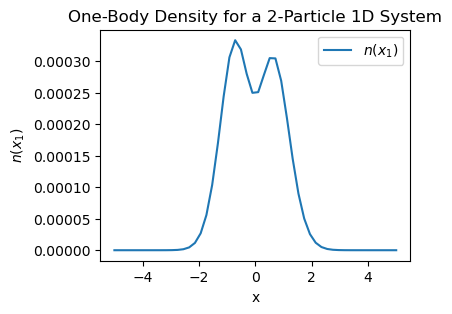

Epoch 00170:  Pde Loss = 8.616e-02, Norm Loss = 6.369e-03
Epoch 00180:  Pde Loss = 6.863e-02, Norm Loss = 5.006e-03


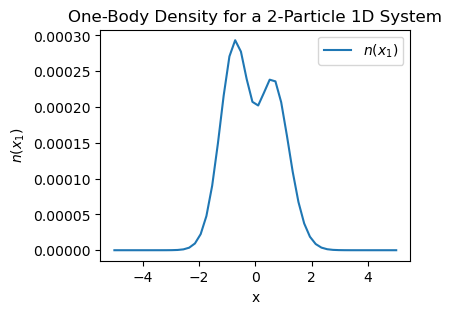

Epoch 00190:  Pde Loss = 7.664e-02, Norm Loss = 1.090e-02
Epoch 00200:  Pde Loss = 6.982e-02, Norm Loss = 7.607e-03


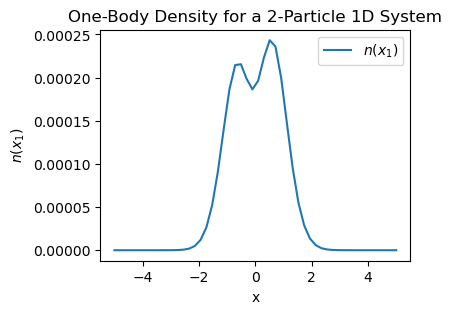

Epoch 00210:  Pde Loss = 7.250e-02, Norm Loss = 9.632e-03
Epoch 00220:  Pde Loss = 6.228e-02, Norm Loss = 1.044e-02


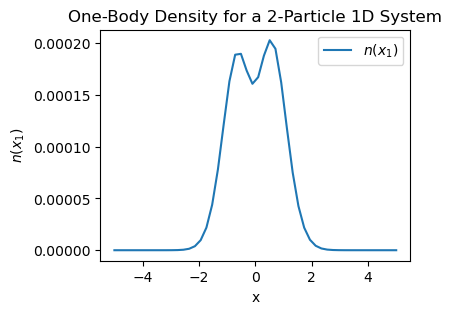

Epoch 00230:  Pde Loss = 6.433e-02, Norm Loss = 1.615e-02
Epoch 00240:  Pde Loss = 5.990e-02, Norm Loss = 1.272e-02


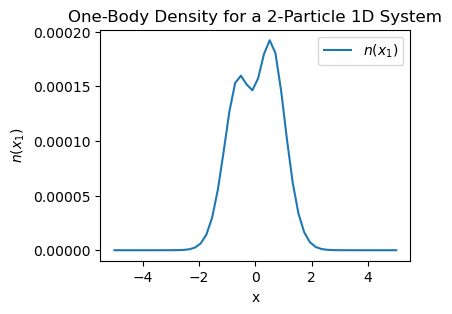

Epoch 00250:  Pde Loss = 5.712e-02, Norm Loss = 1.361e-02
Epoch 00260:  Pde Loss = 5.787e-02, Norm Loss = 1.266e-02


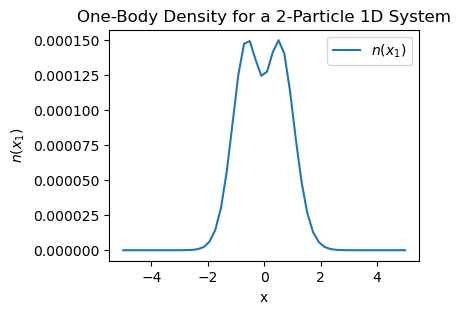

Epoch 00270:  Pde Loss = 5.591e-02, Norm Loss = 1.446e-02
Epoch 00280:  Pde Loss = 5.044e-02, Norm Loss = 1.800e-02


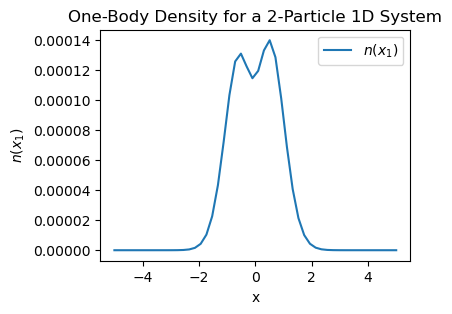

Epoch 00290:  Pde Loss = 5.370e-02, Norm Loss = 1.895e-02
Epoch 00300:  Pde Loss = 5.428e-02, Norm Loss = 1.783e-02


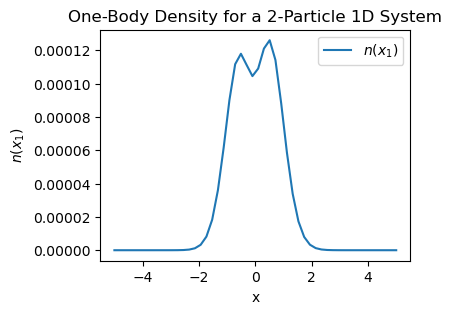

Epoch 00310:  Pde Loss = 5.030e-02, Norm Loss = 1.751e-02
Epoch 00320:  Pde Loss = 4.354e-02, Norm Loss = 1.727e-02


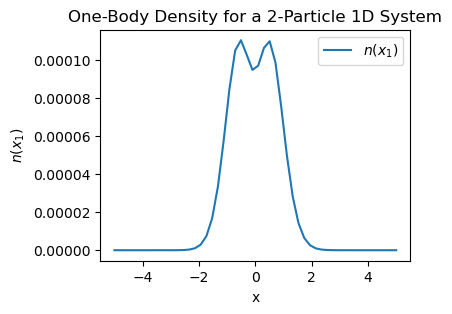

Epoch 00330:  Pde Loss = 4.244e-02, Norm Loss = 1.466e-02
Epoch 00340:  Pde Loss = 4.437e-02, Norm Loss = 1.779e-02


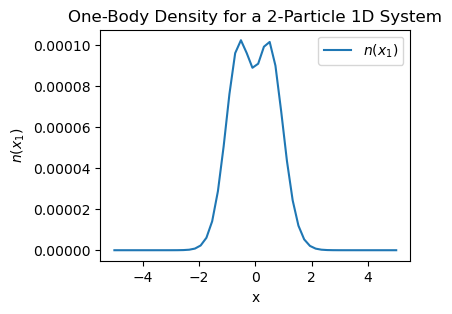

Epoch 00350:  Pde Loss = 4.882e-02, Norm Loss = 2.100e-02
Epoch 00360:  Pde Loss = 4.695e-02, Norm Loss = 2.247e-02


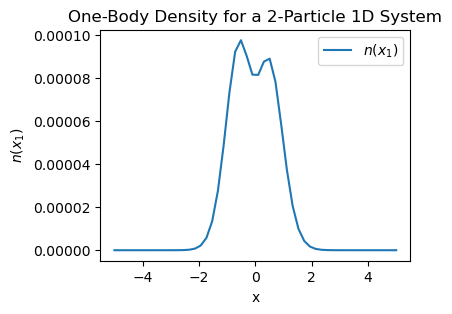

Epoch 00370:  Pde Loss = 4.194e-02, Norm Loss = 1.874e-02
Epoch 00380:  Pde Loss = 4.201e-02, Norm Loss = 2.125e-02


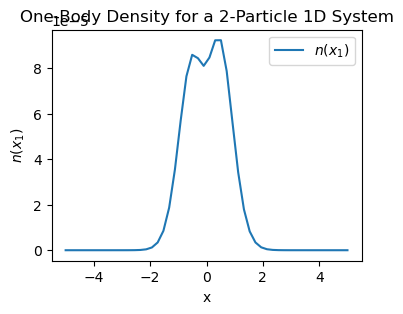

Epoch 00390:  Pde Loss = 3.906e-02, Norm Loss = 1.356e-02
Epoch 00400:  Pde Loss = 4.116e-02, Norm Loss = 2.099e-02


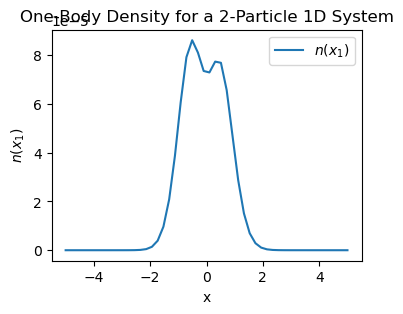

Epoch 00410:  Pde Loss = 3.898e-02, Norm Loss = 2.082e-02
Epoch 00420:  Pde Loss = 3.732e-02, Norm Loss = 1.949e-02


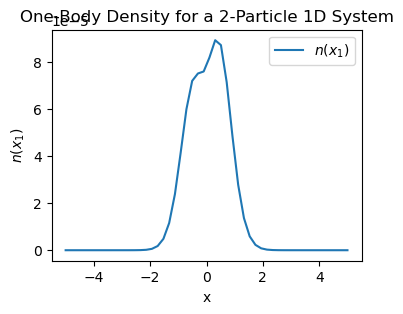

Epoch 00430:  Pde Loss = 3.316e-02, Norm Loss = 1.623e-02
Epoch 00440:  Pde Loss = 3.808e-02, Norm Loss = 1.906e-02


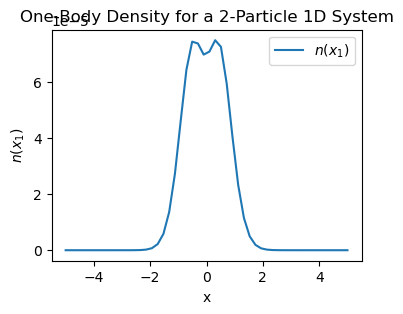

Epoch 00450:  Pde Loss = 3.130e-02, Norm Loss = 1.633e-02
Epoch 00460:  Pde Loss = 3.394e-02, Norm Loss = 1.636e-02


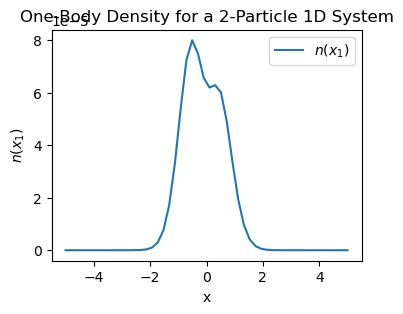

Epoch 00470:  Pde Loss = 3.682e-02, Norm Loss = 1.790e-02
Epoch 00480:  Pde Loss = 3.182e-02, Norm Loss = 1.749e-02


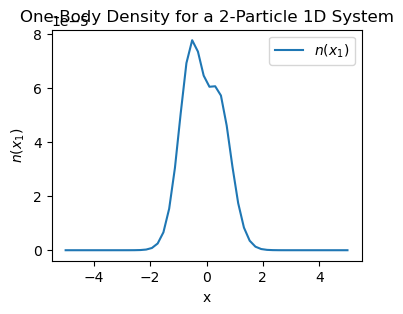

Epoch 00490:  Pde Loss = 3.000e-02, Norm Loss = 1.642e-02
Epoch 00500:  Pde Loss = 2.866e-02, Norm Loss = 1.724e-02


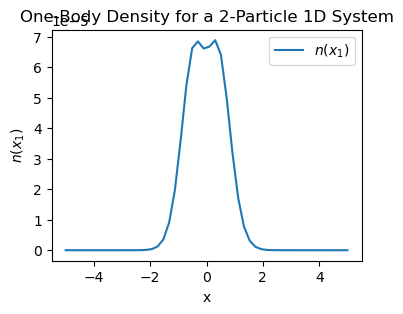

Epoch 00510:  Pde Loss = 2.813e-02, Norm Loss = 1.470e-02
Epoch 00520:  Pde Loss = 2.726e-02, Norm Loss = 1.679e-02


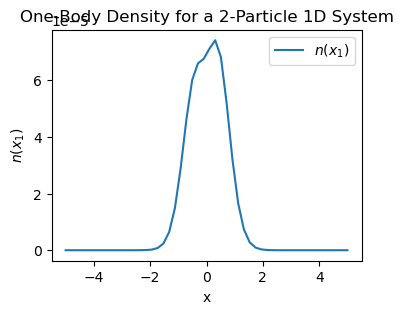

Epoch 00530:  Pde Loss = 2.351e-02, Norm Loss = 1.110e-02
Epoch 00540:  Pde Loss = 2.827e-02, Norm Loss = 1.511e-02


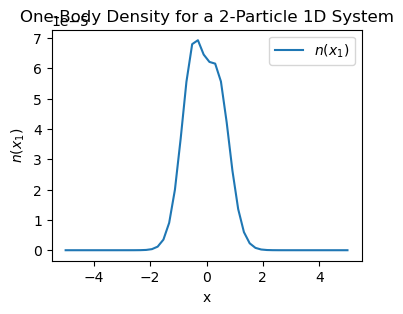

Epoch 00550:  Pde Loss = 2.508e-02, Norm Loss = 1.257e-02
Epoch 00560:  Pde Loss = 2.661e-02, Norm Loss = 1.539e-02


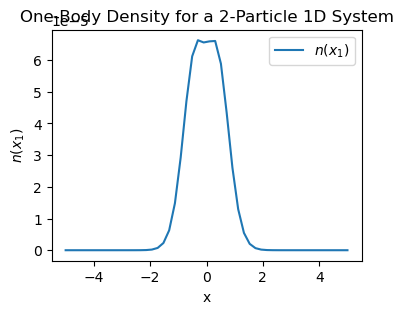

Epoch 00570:  Pde Loss = 2.357e-02, Norm Loss = 1.425e-02
Epoch 00580:  Pde Loss = 2.608e-02, Norm Loss = 9.722e-03


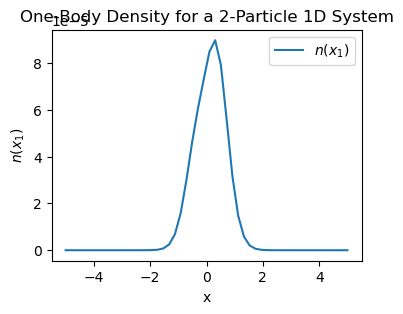

Epoch 00590:  Pde Loss = 2.143e-02, Norm Loss = 1.151e-02
Epoch 00600:  Pde Loss = 2.481e-02, Norm Loss = 1.155e-02


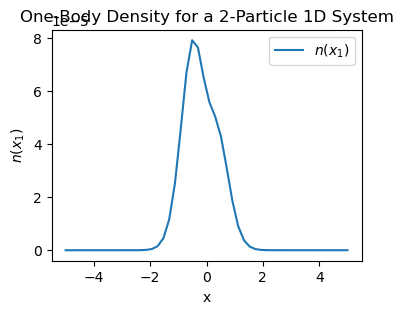

Epoch 00610:  Pde Loss = 1.917e-02, Norm Loss = 9.623e-03
Epoch 00620:  Pde Loss = 2.059e-02, Norm Loss = 1.178e-02


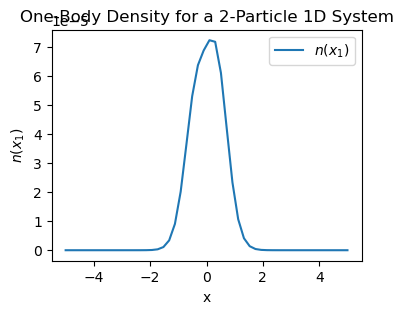

Epoch 00630:  Pde Loss = 1.702e-02, Norm Loss = 8.460e-03
Epoch 00640:  Pde Loss = 1.642e-02, Norm Loss = 7.289e-03


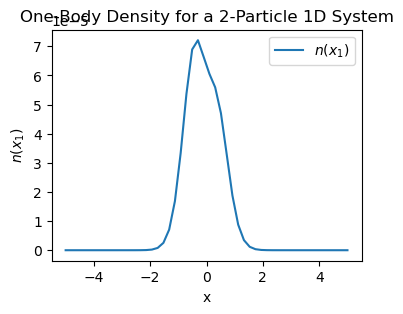

Epoch 00650:  Pde Loss = 1.422e-02, Norm Loss = 5.022e-03
Epoch 00660:  Pde Loss = 1.382e-02, Norm Loss = 5.991e-03


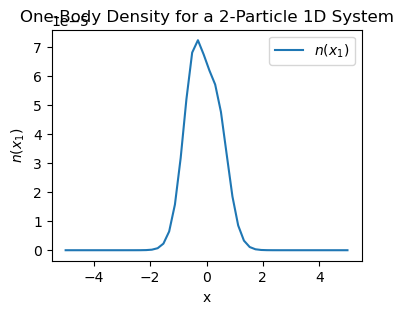

Epoch 00670:  Pde Loss = 1.272e-02, Norm Loss = 7.198e-03
Epoch 00680:  Pde Loss = 1.268e-02, Norm Loss = 3.837e-03


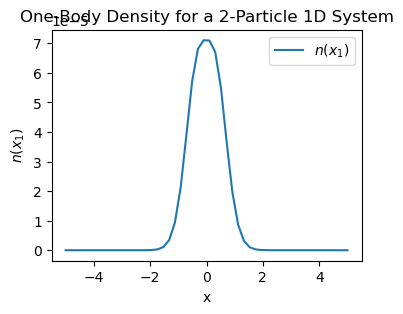

Epoch 00690:  Pde Loss = 1.114e-02, Norm Loss = 3.162e-03
Epoch 00700:  Pde Loss = 1.141e-02, Norm Loss = 3.072e-03


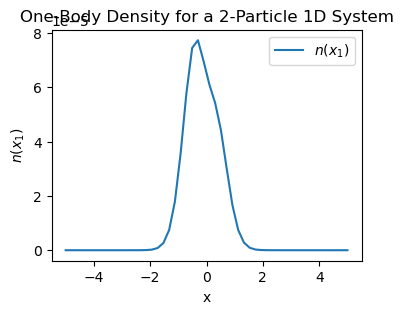

Epoch 00710:  Pde Loss = 1.046e-02, Norm Loss = 4.291e-03
Epoch 00720:  Pde Loss = 1.017e-02, Norm Loss = 2.465e-03


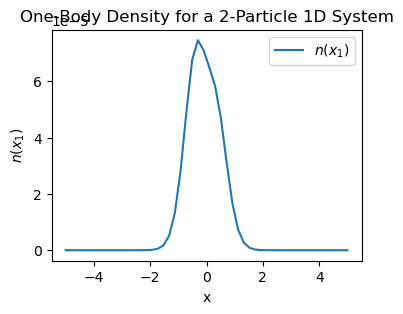

Epoch 00730:  Pde Loss = 9.190e-03, Norm Loss = 2.382e-03
Epoch 00740:  Pde Loss = 1.029e-02, Norm Loss = 2.806e-03


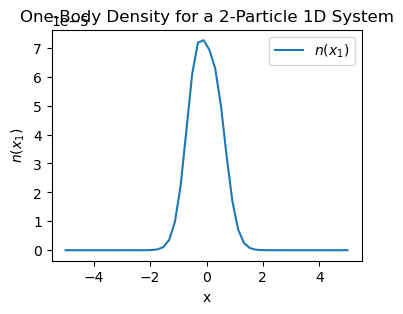

Epoch 00750:  Pde Loss = 7.795e-03, Norm Loss = 1.879e-03
Epoch 00760:  Pde Loss = 9.292e-03, Norm Loss = 5.423e-03


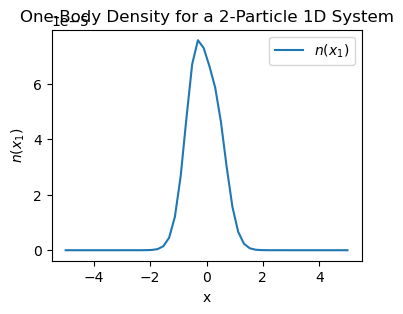

Epoch 00770:  Pde Loss = 7.679e-03, Norm Loss = 9.598e-04
Epoch 00780:  Pde Loss = 1.055e-02, Norm Loss = 8.727e-04


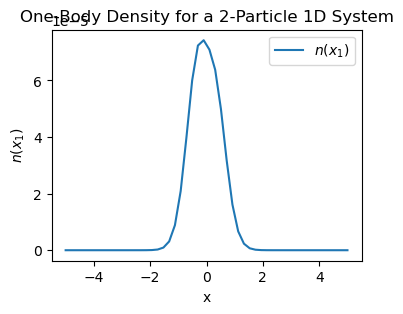

Epoch 00790:  Pde Loss = 7.898e-03, Norm Loss = 1.286e-03


PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [120]:
input_dim = n_particles * d
f_net = PINN(input_dim=input_dim, hidden_dim=64, n_hidden=2).to(device)
optimizer = optim.Adam(list(f_net.parameters()), lr=learning_rate)
train_model(-20,-2.3,f_net,optimizer)

Epoch 00000:  Pde Loss = 6.741e-03, Norm Loss = 4.878e-04


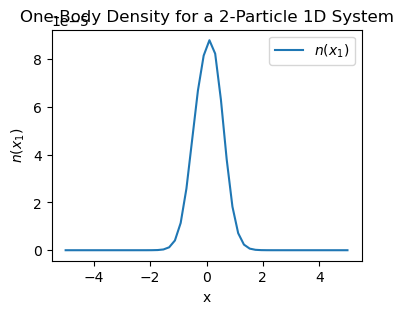

Epoch 00010:  Pde Loss = 6.610e-03, Norm Loss = 6.459e-04
Epoch 00020:  Pde Loss = 7.505e-03, Norm Loss = 7.237e-04


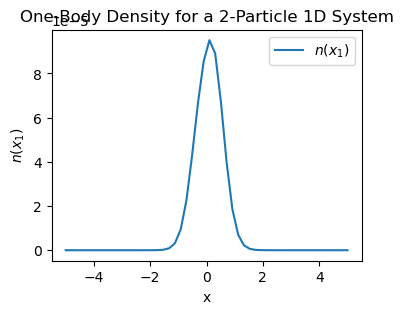

Epoch 00030:  Pde Loss = 6.942e-03, Norm Loss = 1.171e-03
Epoch 00040:  Pde Loss = 6.006e-03, Norm Loss = 1.626e-03


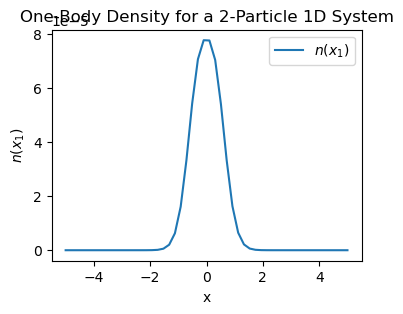

KeyboardInterrupt: 

In [122]:
train_model(-20,-2.3,f_net,optimizer)

Estimated Energy: -2.2760452775935662


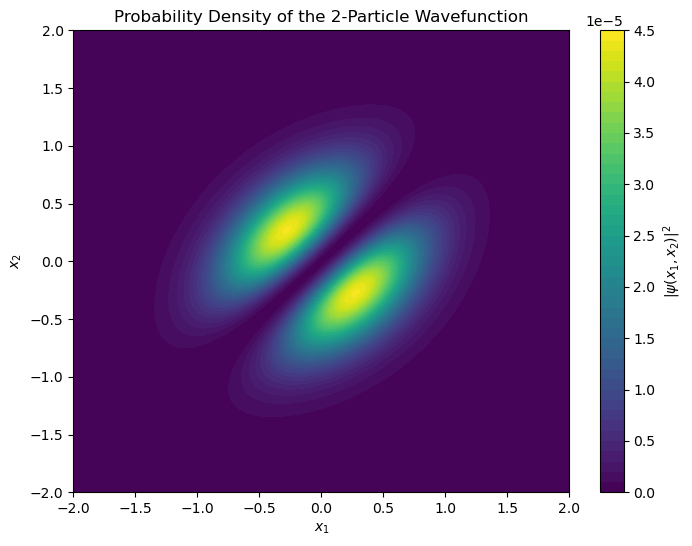

-2.2760452775935662

In [125]:
Energy_plot(-20,f_net)